# 4주차 과제
fashion MNIST 데이터셋을 사용하여 의류 이미지를 분류하는 CNN 만들기

여러가지를 시도해보시면서(레이어 개수, 노드 개수, 활성화 함수, optimizer, 배치 정규화 등등) 가장 정확도가 높은 것만 남기지 마시고 시도했던 모든 버전의 코드와 그 모델의 정확도를 남겨주세요. 적어도 3가지 정도의 버전이 있으면 바람직할 것 같습니다. 이 버전은 무엇을 바꾸고, 무엇을 시도한 버전인지도 작성해주세요.

In [1]:
1

1

In [2]:
import torch #파이토치
import torchvision.datasets as dsets #MNIST 데이터셋을 불러옴
import torchvision.transforms as transforms #이미지 변환 툴
import torch.nn.init #텐서에 초기값을 줌

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## 데이터 불러오기
FashionMNIST

운동화, 셔츠 등 다양한 의류 이미지와 그 종류 라벨로 구성된 computer vision 데이터이다. 한 이미지는 28*28이며 10가지의 종류로 분류된다.

In [4]:
trainset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



# 모델1

학습률 0.001 / 에폭 15 / 배치 사이즈 15

활성화 함수 ReLU

풀링 MaxPool2d

## 초모수 설정

In [ ]:
learning_rate = 0.001 # 가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 15 # 반복학습의 횟수
batch_size = 15 # 한 iteration에서 사용할 데이터 크기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [ ]:
len(train_loader)

4000

In [ ]:
len(test_loader)

667

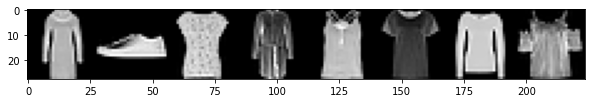

In [ ]:
# 데이터(이미지) 확인해보기
from torchvision import utils

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:8], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

## CNN 클래스 만들기

In [ ]:
# 직접 CNN 클래스를 만들어봅시다.
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride=2))   # pooling

        # second layer
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # fully-connected layer 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # fully-connected layer 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc(out) # fully-connected layer 통과
        return out

In [ ]:
model1 = CNN().to(device)

In [ ]:
# loss function과 optimizer를 정해봅시다.
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

## 모델학습

In [ ]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [ ]:
# 모델을 학습시켜봅시다.
training_model(model = model1, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.511370063
[Epoch:    2] cost = 0.331731647
[Epoch:    3] cost = 0.293437481
[Epoch:    4] cost = 0.267594516
[Epoch:    5] cost = 0.248459384
[Epoch:    6] cost = 0.232258201
[Epoch:    7] cost = 0.220570669
[Epoch:    8] cost = 0.206883907
[Epoch:    9] cost = 0.197418094
[Epoch:   10] cost = 0.185276896
[Epoch:   11] cost = 0.1765977
[Epoch:   12] cost = 0.168466359
[Epoch:   13] cost = 0.161205158
[Epoch:   14] cost = 0.152908951
[Epoch:   15] cost = 0.142818108


## 결과

In [ ]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model1(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9116


# 모델2

학습률 0.01 / 에폭 50 / 배치사이즈 200

레이어 5개

드롭아웃 0.5 추가

In [ ]:
learning_rate = 0.01 # 가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 50 # 반복학습의 횟수
batch_size = 200 # 한 iteration에서 사용할 데이터 크기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out

In [ ]:
model2 = CNN().to(device)

In [ ]:
# loss function과 optimizer를 정해봅시다.
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [15]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch
        
    if epoch % 10 ==0:
      print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [ ]:
# 모델을 학습시켜봅시다.
training_model(model = model2, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.699974477
[Epoch:   11] cost = 0.332715154
[Epoch:   21] cost = 0.312743485
[Epoch:   31] cost = 0.306744069
[Epoch:   41] cost = 0.299075812


In [ ]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model2(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.8598


# 모델3
학습률 0.001 / 에폭 15 / 배치사이즈 15

nn.Tanh() 활성화 함수 변경

In [ ]:
learning_rate = 0.001 # 가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 15 # 반복학습의 횟수
batch_size = 15 # 한 iteration에서 사용할 데이터 크기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 1채널, 32채널
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_normal_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.Tanh(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out

In [ ]:
model3 = CNN().to(device)

In [ ]:
# loss function과 optimizer를 정해봅시다.
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [ ]:
# 모델을 학습시켜봅시다.
training_model(model = model3, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.430397034
[Epoch:   11] cost = 0.231742546


In [ ]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model3(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.894


# 모델4
학습률 0.001 / 에폭 15 / 배치 사이즈 15

레이어 4개

풀링 AvgPool

채널 수 변경

optimizer Adagrad로 변경

In [ ]:
learning_rate = 0.001 # 가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 15 # 반복학습의 횟수
batch_size = 15 # 한 iteration에서 사용할 데이터 크기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5 

        # first layer (28*28*1->14*14*64) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # 1채널, 64채널
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # second layer (14*14*64->7*7*32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))

        # third layer(fully-connected layer, 7x7x128 -> 128)
        self.fc1 = torch.nn.Linear(7 * 7 * 32, 128, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화

        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.Tanh(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # forth layer(fully-connected layer, 128 -> 10) 
        self.fc2 = torch.nn.Linear(128, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer3(out)   # third layer 통과
        out = self.fc2(out)   # fourth layer 통과
        return out

In [ ]:
model4 = CNN().to(device)

In [ ]:
# loss function과 optimizer를 정해봅시다.
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adagrad(model4.parameters(), lr=learning_rate)   #optimizer 정의, Adagrad으로 설정

In [ ]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch
        
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [ ]:
# 모델을 학습시켜봅시다.
training_model(model = model4, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.734832823
[Epoch:    2] cost = 0.625704348
[Epoch:    3] cost = 0.594213545
[Epoch:    4] cost = 0.577165425
[Epoch:    5] cost = 0.561981678
[Epoch:    6] cost = 0.551044106
[Epoch:    7] cost = 0.541154802
[Epoch:    8] cost = 0.531361282
[Epoch:    9] cost = 0.527243078
[Epoch:   10] cost = 0.52305907
[Epoch:   11] cost = 0.514600575
[Epoch:   12] cost = 0.511136174
[Epoch:   13] cost = 0.506769836
[Epoch:   14] cost = 0.501660526
[Epoch:   15] cost = 0.498465985


In [ ]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model4(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.8126


# 모델5

학습률 0.001 / 에폭 20 / 배치 사이즈 50

드롭아웃 비율 0.6으로 변경

배치정규화 추가

optimizer Adam으로 설정

In [ ]:
learning_rate = 0.001 # 가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 20 # 반복학습의 횟수
batch_size = 50 # 한 iteration에서 사용할 데이터 크기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [5]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.4 

        # first layer (28*28*1->14*14*64) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # 1채널, 64채널
            torch.nn.BatchNorm2d(64), # 배치정규화
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # second layer (14*14*64->7*7*32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))

        # third layer(fully-connected layer, 7*7*32 -> 625)
        self.fc1 = torch.nn.Linear(7 * 7 * 32, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화

        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.Tanh(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # forth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer3(out)   # third layer 통과
        out = self.fc2(out)   # fourth layer 통과
        return out

In [11]:
model5 = CNN().to(device)

In [12]:
# loss function과 optimizer를 정해봅시다.
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [ ]:
# 모델을 학습시켜봅시다.
training_model(model = model5, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.569609463
[Epoch:    2] cost = 0.386559367
[Epoch:    3] cost = 0.34604761
[Epoch:    4] cost = 0.319106758
[Epoch:    5] cost = 0.298578203
[Epoch:    6] cost = 0.28658703
[Epoch:    7] cost = 0.274032146
[Epoch:    8] cost = 0.26293388
[Epoch:    9] cost = 0.254580587
[Epoch:   10] cost = 0.247358605
[Epoch:   11] cost = 0.238408178
[Epoch:   12] cost = 0.231786773
[Epoch:   13] cost = 0.225344211
[Epoch:   14] cost = 0.219386309
[Epoch:   15] cost = 0.215875268
[Epoch:   16] cost = 0.210189298
[Epoch:   17] cost = 0.205320269
[Epoch:   18] cost = 0.201146767
[Epoch:   19] cost = 0.199703217
[Epoch:   20] cost = 0.193369016


In [ ]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model5(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9029


# 모델6

에폭 50으로 높이기

In [7]:
learning_rate = 0.001 # 가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 50 # 반복학습의 횟수
batch_size = 50 # 한 iteration에서 사용할 데이터 크기

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [13]:
model6 = CNN().to(device)

In [14]:
# loss function과 optimizer를 정해봅시다.
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model6.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [16]:
# 모델을 학습시켜봅시다.
training_model(model = model6, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.544044614
[Epoch:   11] cost = 0.231538415
[Epoch:   21] cost = 0.182320371
[Epoch:   31] cost = 0.147957921
[Epoch:   41] cost = 0.123662099


In [18]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model6(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9096
